In [77]:
import os
import glob
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import OrderedDict

In [78]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [79]:
# Define RRDBNet architecture
def make_layer(block, n_layers):
    layers = []
    for _ in range(n_layers):
        layers.append(block())
    return nn.Sequential(*layers)

class ResidualDenseBlock_5C(nn.Module):
    def __init__(self, nf=64, gc=32, bias=True):
        super(ResidualDenseBlock_5C, self).__init__()
        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1, bias=bias)
        self.conv2 = nn.Conv2d(nf + gc, gc, 3, 1, 1, bias=bias)
        self.conv3 = nn.Conv2d(nf + 2 * gc, gc, 3, 1, 1, bias=bias)
        self.conv4 = nn.Conv2d(nf + 3 * gc, gc, 3, 1, 1, bias=bias)
        self.conv5 = nn.Conv2d(nf + 4 * gc, nf, 3, 1, 1, bias=bias)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x

class RRDB(nn.Module):
    def __init__(self, nf, gc=32):
        super(RRDB, self).__init__()
        self.RDB1 = ResidualDenseBlock_5C(nf, gc)
        self.RDB2 = ResidualDenseBlock_5C(nf, gc)
        self.RDB3 = ResidualDenseBlock_5C(nf, gc)

    def forward(self, x):
        out = self.RDB1(x)
        out = self.RDB2(out)
        out = self.RDB3(out)
        return out * 0.2 + x

class RRDBNet(nn.Module):
    def __init__(self, in_nc, out_nc, nf, nb, gc=32):
        super(RRDBNet, self).__init__()
        RRDB_block_f = lambda: RRDB(nf, gc)

        self.conv_first = nn.Conv2d(in_nc, nf, 3, 1, 1, bias=True)
        self.RRDB_trunk = make_layer(RRDB_block_f, nb)
        self.trunk_conv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.upconv1 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.upconv2 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.HRconv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.conv_last = nn.Conv2d(nf, out_nc, 3, 1, 1, bias=True)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        fea = self.conv_first(x)
        trunk = self.trunk_conv(self.RRDB_trunk(fea))
        fea = fea + trunk
        fea = self.lrelu(self.upconv1(F.interpolate(fea, scale_factor=2, mode='nearest')))
        fea = self.lrelu(self.upconv2(F.interpolate(fea, scale_factor=2, mode='nearest')))
        out = self.conv_last(self.lrelu(self.HRconv(fea)))
        return out


In [80]:
# Function to create interpolated model
def interpolate_model(alpha):
    try:
        net_PSNR = torch.load('models\RRDB_ESRGAN_x4.pth', map_location=device)
        net_ESRGAN = torch.load('models\RRDB_ESRGAN_x4.pth', map_location=device)
        net_interp = OrderedDict()

        for k, v_PSNR in net_PSNR.items():
            v_ESRGAN = net_ESRGAN[k]
            net_interp[k] = (1 - alpha) * v_PSNR + alpha * v_ESRGAN

        return net_interp
    except Exception as e:
        print(f"Error creating interpolated model: {str(e)}")
        return None

# Create interpolated models
print("Creating interpolated models...")
interp_05 = interpolate_model(0.5)
interp_08 = interpolate_model(0.8)

# Save interpolated models
if interp_05 is not None and interp_08 is not None:
    torch.save(interp_05, 'models/interp_05.pth')
    torch.save(interp_08, 'models/interp_08.pth')
    print("Interpolated models created and saved.")
else:
    print("Failed to create interpolated models.")

<>:4: SyntaxWarning: invalid escape sequence '\R'
<>:5: SyntaxWarning: invalid escape sequence '\R'
<>:4: SyntaxWarning: invalid escape sequence '\R'
<>:5: SyntaxWarning: invalid escape sequence '\R'
C:\Users\abdul\AppData\Local\Temp\ipykernel_4888\926984491.py:4: SyntaxWarning: invalid escape sequence '\R'
  net_PSNR = torch.load('models\RRDB_ESRGAN_x4.pth', map_location=device)
C:\Users\abdul\AppData\Local\Temp\ipykernel_4888\926984491.py:5: SyntaxWarning: invalid escape sequence '\R'
  net_ESRGAN = torch.load('models\RRDB_ESRGAN_x4.pth', map_location=device)
C:\Users\abdul\AppData\Local\Temp\ipykernel_4888\926984491.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, 

Creating interpolated models...


C:\Users\abdul\AppData\Local\Temp\ipykernel_4888\926984491.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_ESRGAN = torch.load('models\RRDB_ESRGAN_x4.pth', map_locat

Interpolated models created and saved.


In [81]:
# Define model paths
model_paths = {
    'PSNR': 'models/RRDB_PSNR_x4.pth',
    'ESRGAN': 'models/RRDB_ESRGAN_x4.pth',
    'Interp_0.5': 'models/interp_05.pth',
    'Interp_0.8': 'models/interp_08.pth'
}

In [82]:
# Function to load model
def load_model(model_path):
    model = RRDBNet(3, 3, 64, 23, gc=32)
    model.load_state_dict(torch.load(model_path), strict=True)
    model.eval()
    return model.to(device)

In [83]:
# Function to process image
def process_image(model, img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = img * 1.0 / 255
    img = torch.from_numpy(np.transpose(img[:, :, [2, 1, 0]], (2, 0, 1))).float()
    img_LR = img.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_LR).data.squeeze().float().cpu().clamp_(0, 1).numpy()

    output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))
    return (output * 255.0).round().astype(np.uint8)

In [84]:
# Function to calculate PSNR
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))


In [85]:
# Function to calculate SSIM
def calculate_ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())
    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

In [86]:
# Modified function to load model
def load_model(model_path):
    model = RRDBNet(3, 3, 64, 23, gc=32)
    try:
        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict, strict=True)
        print(f"Successfully loaded model from {model_path}")
    except RuntimeError as e:
        print(f"Error loading model from {model_path}: {str(e)}")
        print("Attempting to load with strict=False...")
        try:
            model.load_state_dict(state_dict, strict=False)
            print(f"Loaded model from {model_path} with strict=False")
        except Exception as e:
            print(f"Failed to load model from {model_path}: {str(e)}")
            return None
    except FileNotFoundError:
        print(f"Model file not found: {model_path}")
        return None
    except Exception as e:
        print(f"Unexpected error loading model from {model_path}: {str(e)}")
        return None

    model.eval()
    return model.to(device)

In [87]:
# Load all models
models = {}
for name, path in model_paths.items():
    print(f"Attempting to load {name} model...")
    model = load_model(path)
    if model is not None:
        models[name] = model
    else:
        print(f"Skipping {name} model due to loading failure")


Attempting to load PSNR model...


C:\Users\abdul\AppData\Local\Temp\ipykernel_4888\2502978845.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Successfully loaded model from models/RRDB_PSNR_x4.pth
Attempting to load ESRGAN model...
Successfully loaded model from models/RRDB_ESRGAN_x4.pth
Attempting to load Interp_0.5 model...
Successfully loaded model from models/interp_05.pth
Attempting to load Interp_0.8 model...
Successfully loaded model from models/interp_08.pth


In [76]:
import cv2
# Function to upscale image using pretrained models
def get_upscaled_images(img_small, filemodel_filepath, modelname, scale):
    # Initialize the super-resolution model
    model_pretrained = cv2.dnn_superres.DnnSuperResImpl_create()
    print("Reading model file {}".format(filemodel_filepath))
  
    # Load the model file
    model_pretrained.readModel(filemodel_filepath)
    
    # Set the model and scale
    model_pretrained.setModel(modelname, scale)
  
    # Upscale the image
    img_upscaled = model_pretrained.upsample(img_small)
    return img_upscaled

# Example usage with different models
img_upscaled1 = get_upscaled_images(img_small, "pretrained_models/EDSR_x4.pb", "edsr", 4)
img_upscaled2 = get_upscaled_images(img_small, "pretrained_models/ESPCN_x4.pb", "espcn", 4)
img_upscaled3 = get_upscaled_images(img_small, "pretrained_models/FSRCNN_x4.pb", "fsrcnn", 4)
img_upscaled4 = get_upscaled_images(img_small, "pretrained_models/LapSRN_x4.pb", "lapsrn", 4)

# Print the shape of the upscaled images
print(img_upscaled1.shape, img_upscaled2.shape, img_upscaled3.shape, img_upscaled4.shape)


Reading model file pretrained_models/EDSR_x4.pb


TypeError: 'module' object is not callable

In [88]:
def process_image(model, img_path):
    # Read image in BGR format (OpenCV default)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)

    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Normalize to [0, 1]
    img = img.astype(np.float32) / 255.

    # Convert to tensor and add batch dimension
    img = torch.from_numpy(np.transpose(img, (2, 0, 1))).float().unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img).squeeze().float().cpu().clamp_(0, 1).numpy()

    # Convert back to uint8 and BGR for saving
    output = (np.transpose(output, (1, 2, 0)) * 255.0).round().astype(np.uint8)
    output = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)

    return output

In [89]:
def process_and_display(img_path):
    # Read original image
    original = cv2.imread(img_path)
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    # Process image with each model
    results = {}
    for name, model in models.items():
        print(f"Processing with {name} model...")
        result = process_image(model, img_path)
        if result is not None:
            results[name] = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)  # Convert back to RGB for display
        else:
            print(f"Skipping {name} model due to processing failure")

    # Calculate metrics
    metrics = {}
    for name, result in results.items():
        print(f"Calculating metrics for {name} model...")
        # Resize original image to match the dimensions of the processed image
        resized_original = cv2.resize(original, (result.shape[1], result.shape[0]), interpolation=cv2.INTER_CUBIC)
        metrics[name] = {
            'PSNR': calculate_psnr(resized_original, result),
            'SSIM': calculate_ssim(resized_original, result)
        }

    # Display results
    fig, axes = plt.subplots(2, 3, figsize=(20, 15))
    fig.suptitle(f'Super-Resolution Results for {os.path.basename(img_path)}', fontsize=16)

    axes[0, 0].imshow(original)
    axes[0, 0].set_title('Original')
    axes[0, 0].axis('off')

    for idx, (name, result) in enumerate(results.items(), 1):
        row, col = divmod(idx, 3)
        axes[row, col].imshow(result)
        axes[row, col].set_title(f'{name}\nPSNR: {metrics[name]["PSNR"]:.2f}, SSIM: {metrics[name]["SSIM"]:.4f}')
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

    return metrics


Processing LR\baboon.png
Processing with PSNR model...
Processing with ESRGAN model...
Processing with Interp_0.5 model...
Processing with Interp_0.8 model...
Calculating metrics for PSNR model...
Calculating metrics for ESRGAN model...
Calculating metrics for Interp_0.5 model...
Calculating metrics for Interp_0.8 model...


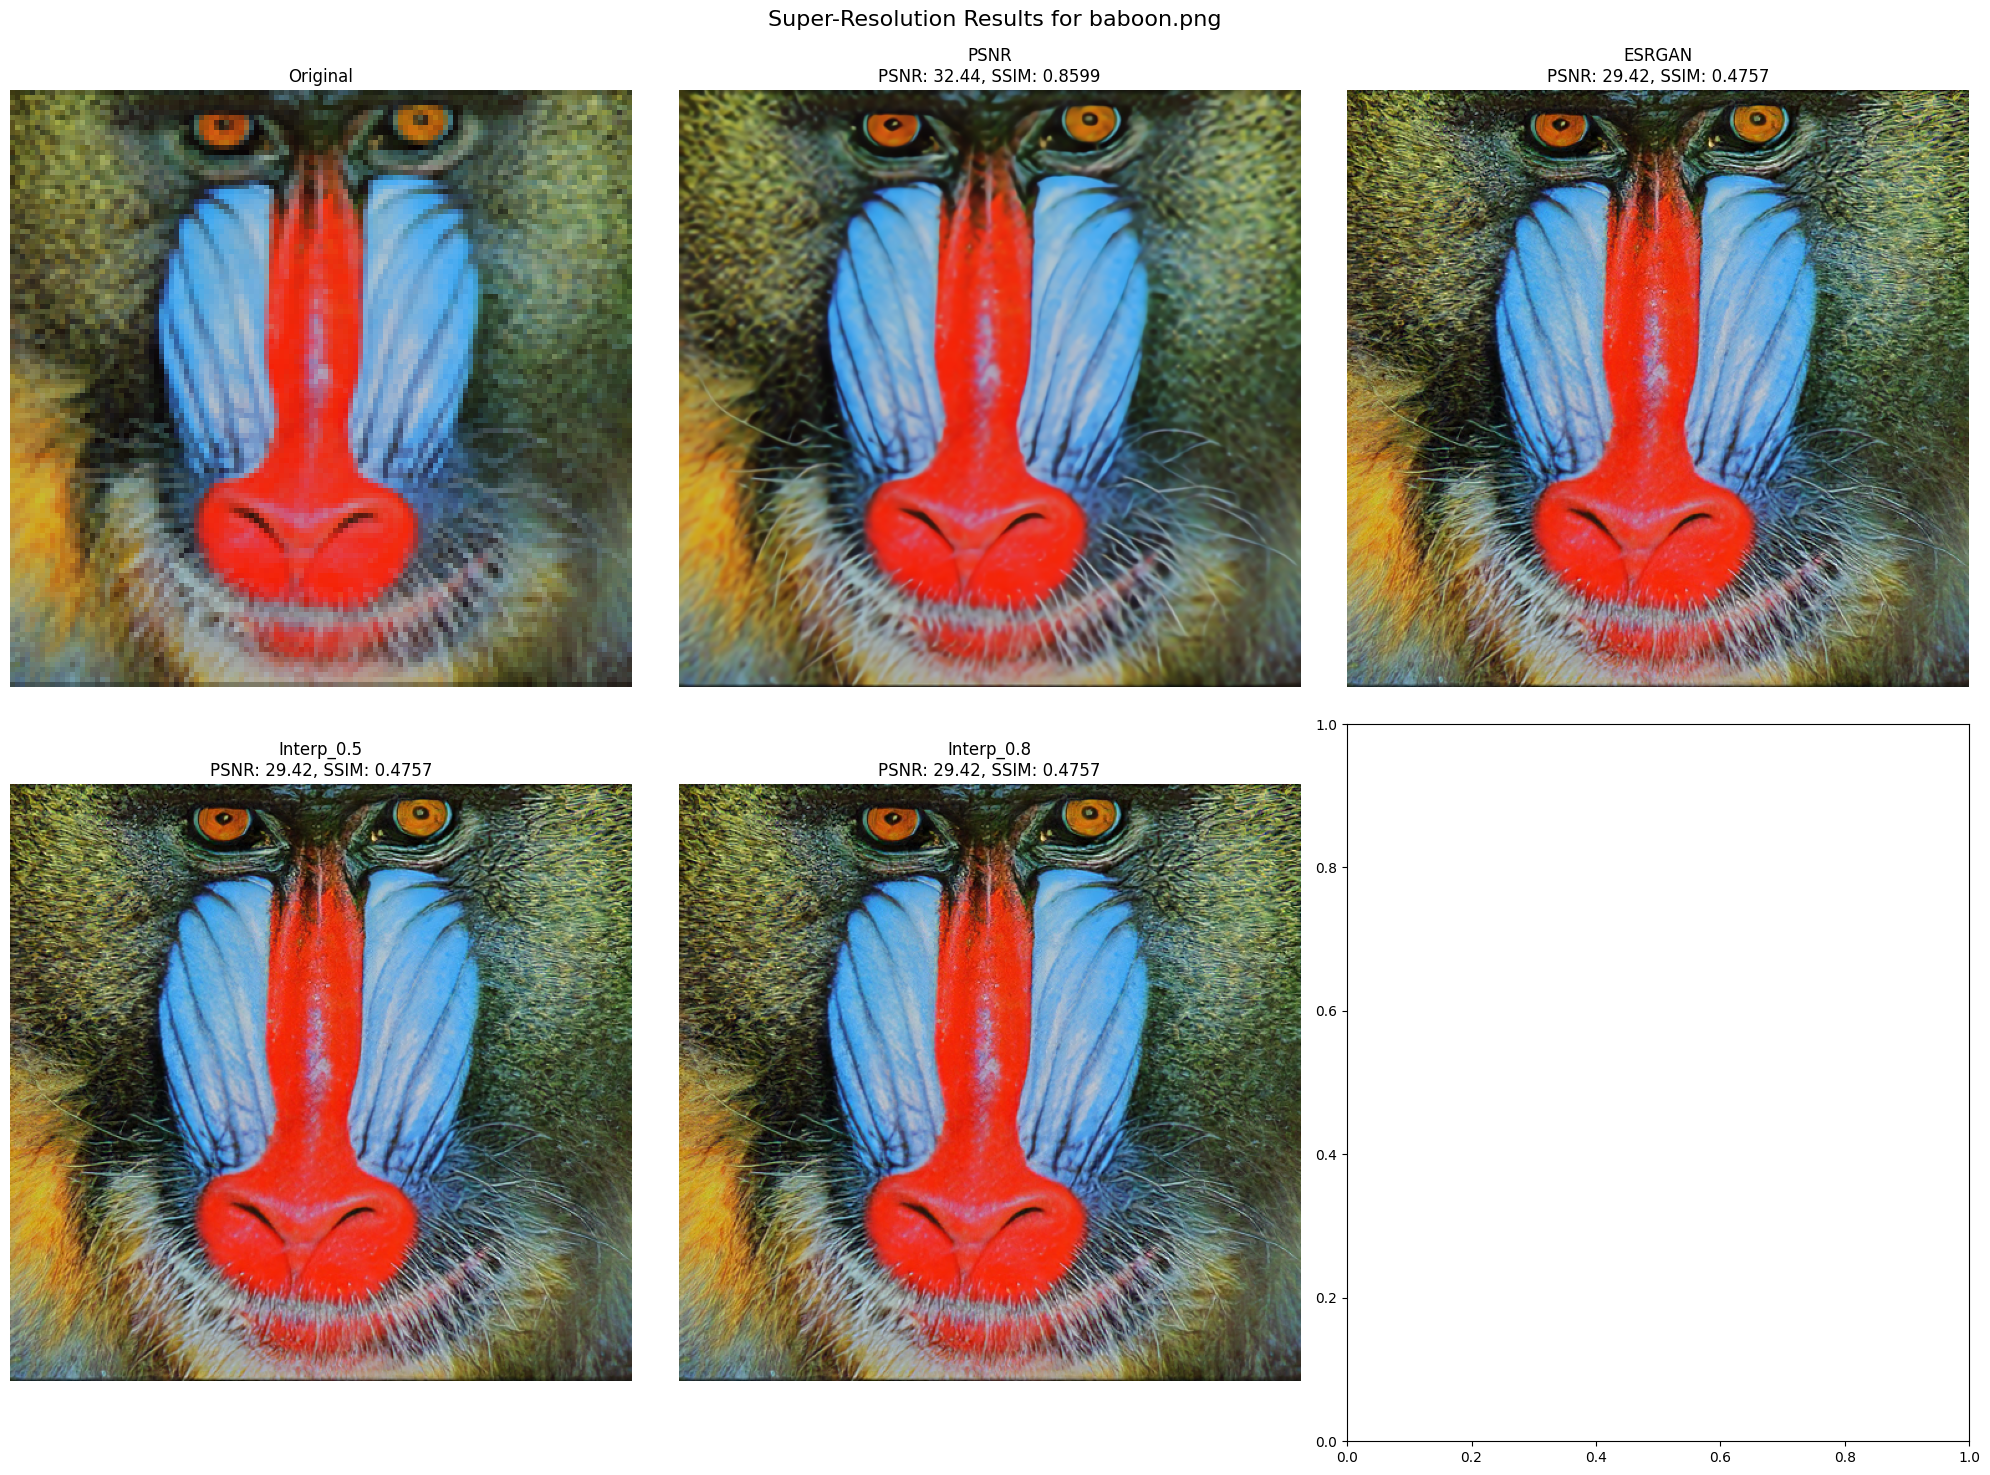


Metrics:
Model                 PSNR       SSIM
-----------------------------------
PSNR                 32.44     0.8599
ESRGAN               29.42     0.4757
Interp_0.5           29.42     0.4757
Interp_0.8           29.42     0.4757



Processing LR\comic.png
Processing with PSNR model...
Processing with ESRGAN model...
Processing with Interp_0.5 model...
Processing with Interp_0.8 model...
Calculating metrics for PSNR model...
Calculating metrics for ESRGAN model...
Calculating metrics for Interp_0.5 model...
Calculating metrics for Interp_0.8 model...


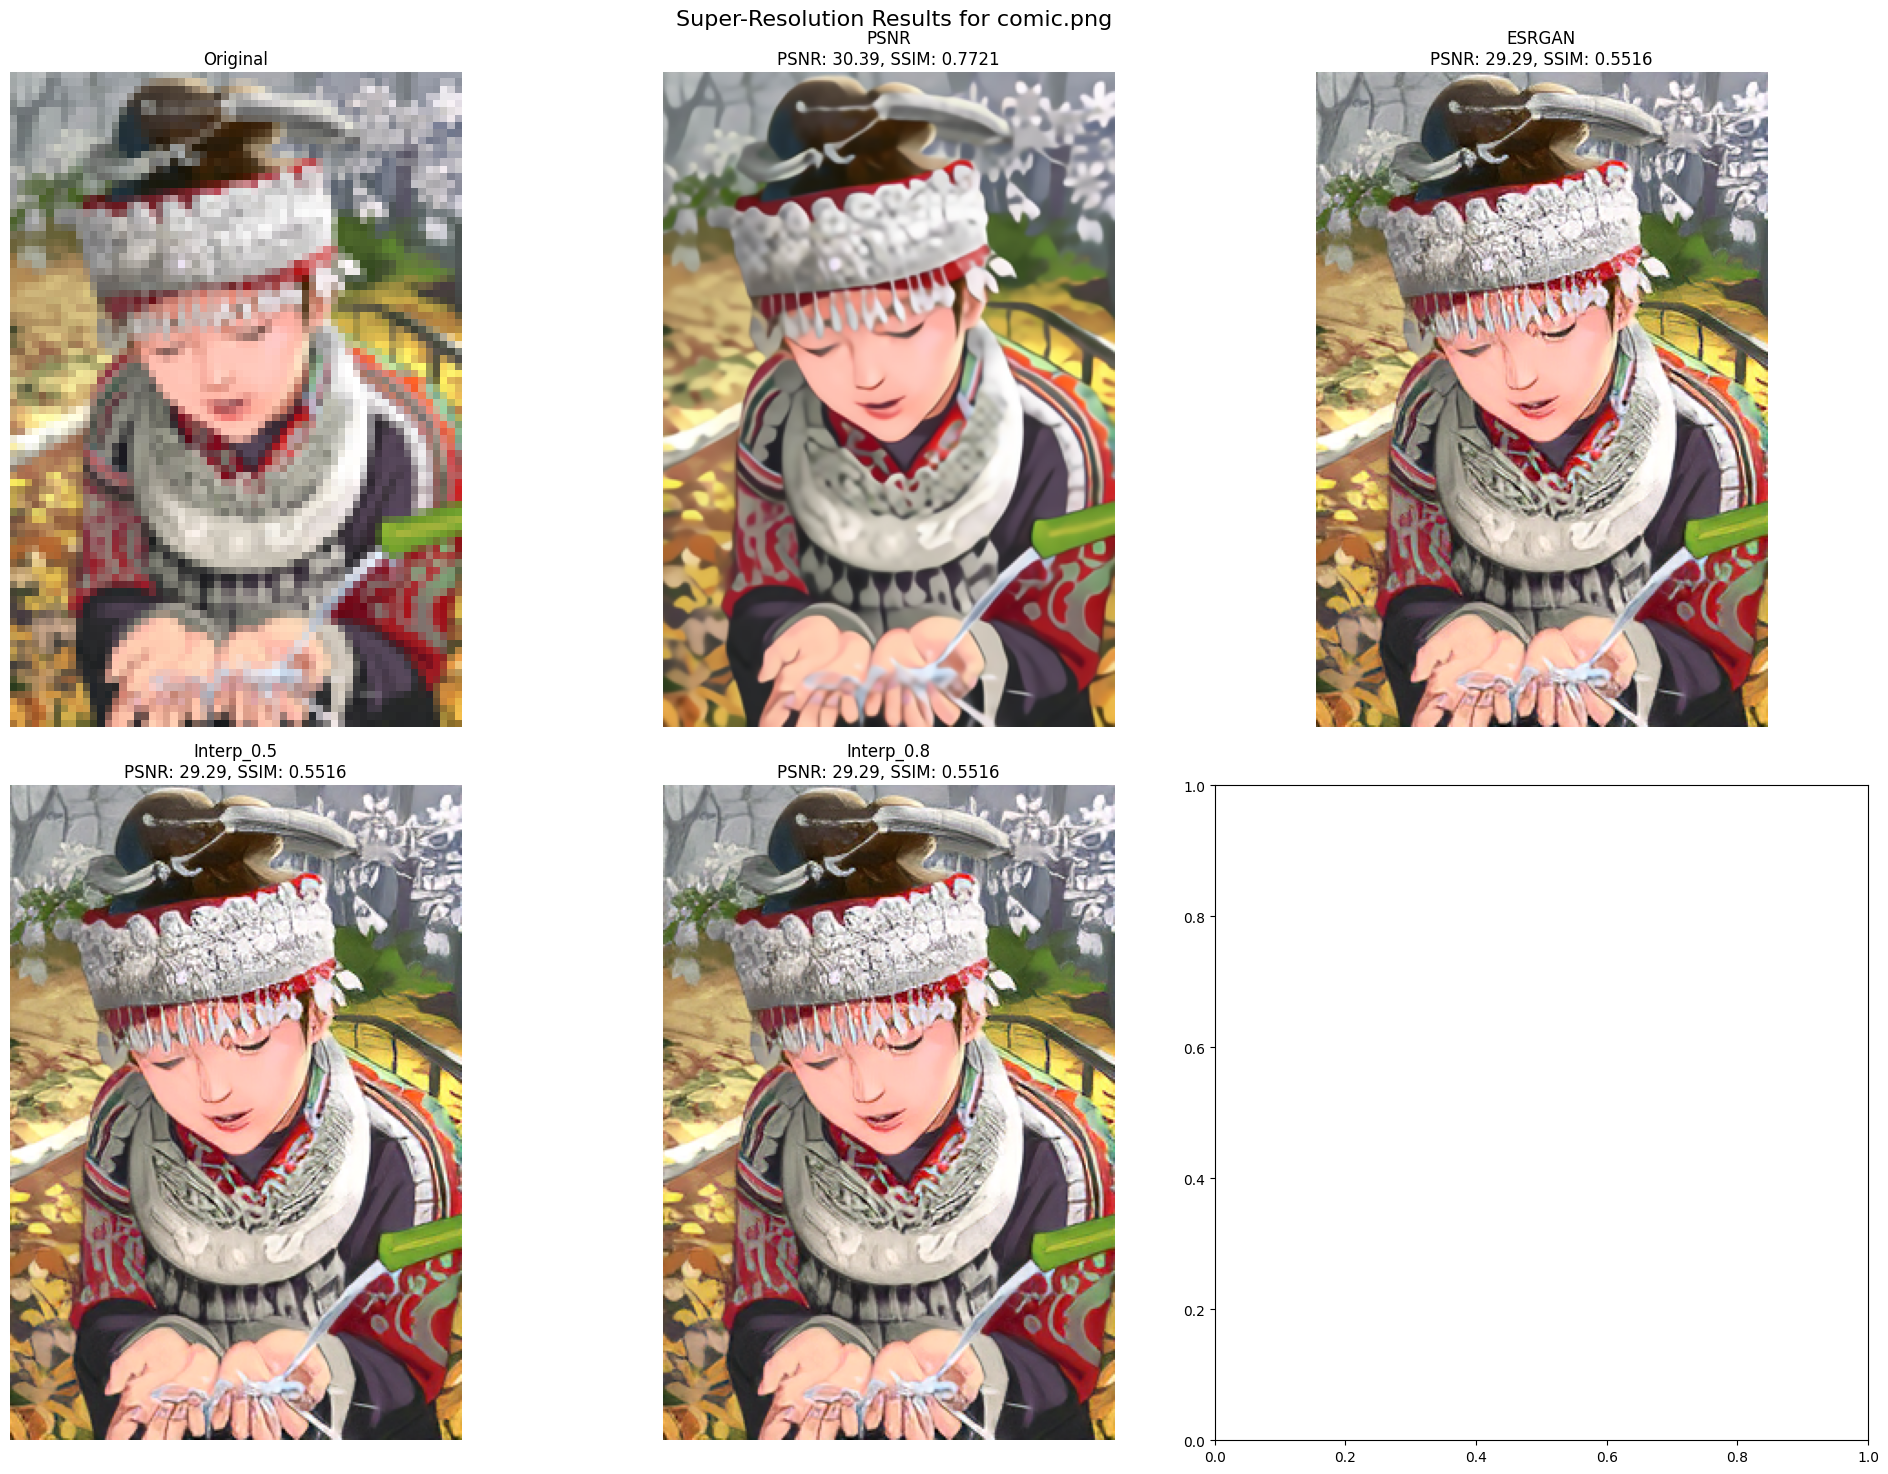


Metrics:
Model                 PSNR       SSIM
-----------------------------------
PSNR                 30.39     0.7721
ESRGAN               29.29     0.5516
Interp_0.5           29.29     0.5516
Interp_0.8           29.29     0.5516


Image processing completed.


In [90]:
# Process images
test_img_folder = 'LR/*'
for img_path in glob.glob(test_img_folder)[:3]:  # Process first 3 images
    print(f"\nProcessing {img_path}")
    try:
        metrics = process_and_display(img_path)

        # Print metrics in a table format
        print("\nMetrics:")
        print(f"{'Model':<15} {'PSNR':>10} {'SSIM':>10}")
        print("-" * 35)
        for model, values in metrics.items():
            print(f"{model:<15} {values['PSNR']:10.2f} {values['SSIM']:10.4f}")
        print("\n")
    except KeyboardInterrupt:
        print("\nProcessing interrupted by user. Moving to the next image.")
        continue
    except Exception as e:
        print(f"\nUnexpected error processing {img_path}: {str(e)}")
        continue

print("Image processing completed.")

In [40]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(img1, img2):
    # Ensure the images have the same shape
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

    # Convert images to float32 if they're not already
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    # Normalize images to [0, 1] range if they're not already
    if img1.max() > 1.0:
        img1 /= 255.0
    if img2.max() > 1.0:
        img2 /= 255.0

    # Ensure the images have 3 channels (RGB)
    if len(img1.shape) == 2:
        img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
    if len(img2.shape) == 2:
        img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)

    # Calculate SSIM
    min_dim = min(img1.shape[0], img1.shape[1])
    win_size = min(7, min_dim)  # Use 7 or smaller odd number

    # Ensure win_size is odd
    if win_size % 2 == 0:
        win_size -= 1

    return ssim(img1, img2, win_size=win_size, channel_axis=2, data_range=1.0)

In [41]:
# Aggregate results
aggregate_metrics = {model: {'PSNR': [], 'SSIM': []} for model in models.keys()}

for img_path in glob.glob(test_img_folder):
    try:
        original = cv2.imread(img_path)
        if original is None:
            print(f"Error: Unable to read image {img_path}")
            continue
        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

        print(f"Processing {img_path} (shape: {original.shape})")

        for name, model in models.items():
            result = process_image(model, img_path)
            if result is None:
                print(f"Error: Unable to process image {img_path} with model {name}")
                continue
            # Convert result back to RGB for metric calculation
            result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

            # Normalize images to [0, 1] range for PSNR calculation
            original_norm = original.astype(np.float32) / 255.0
            result_norm = result_rgb.astype(np.float32) / 255.0

            psnr = calculate_psnr(original_norm, result_norm)
            ssim_value = calculate_ssim(original_norm, result_norm)

            aggregate_metrics[name]['PSNR'].append(psnr)
            aggregate_metrics[name]['SSIM'].append(ssim_value)

            print(f"  {name} model - PSNR: {psnr:.2f}, SSIM: {ssim_value:.4f}")

    except Exception as e:
        print(f"Error processing {img_path}: {str(e)}")
        continue

# Calculate average metrics
avg_metrics = {model: {metric: np.mean(values) if values else np.nan for metric, values in metrics.items()}
               for model, metrics in aggregate_metrics.items()}

# Print aggregate results
print("\nAggregate Results:")
print(f"{'Model':<15} {'Avg PSNR':>10} {'Avg SSIM':>10}")
print("-" * 35)
for model, values in avg_metrics.items():
    print(f"{model:<15} {values['PSNR']:10.2f} {values['SSIM']:10.4f}")

Processing LR\baboon.png (shape: (120, 125, 3))
Error processing LR\baboon.png: operands could not be broadcast together with shapes (120,125,3) (480,500,3) 
Processing LR\comic.png (shape: (90, 62, 3))
Error processing LR\comic.png: operands could not be broadcast together with shapes (90,62,3) (360,248,3) 

Aggregate Results:
Model             Avg PSNR   Avg SSIM
-----------------------------------
PSNR                   nan        nan
ESRGAN                 nan        nan
Interp_0.5             nan        nan
Interp_0.8             nan        nan


In [42]:
# Calculate average metrics
avg_metrics = {model: {metric: np.mean(values) for metric, values in metrics.items()}
               for model, metrics in aggregate_metrics.items()}

In [43]:
# Print aggregate results
print("Aggregate Results:")
print(f"{'Model':<15} {'Avg PSNR':>10} {'Avg SSIM':>10}")
print("-" * 35)
for model, values in avg_metrics.items():
    print(f"{model:<15} {values['PSNR']:10.2f} {values['SSIM']:10.4f}")

Aggregate Results:
Model             Avg PSNR   Avg SSIM
-----------------------------------
PSNR                   nan        nan
ESRGAN                 nan        nan
Interp_0.5             nan        nan
Interp_0.8             nan        nan
